sources

https://scikit-learn.org/stable/modules/svm.html
https://levelup.gitconnected.com/text-cleansing-in-nlp-tasks-594b93d648d6
https://medium.com/analytics-vidhya/comprehensive-hands-on-guide-to-twitter-sentiment-analysis-with-dataset-and-code-960c055ada3f
https://www.kaggle.com/datasets/kazanova/sentiment140
https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners?scriptVersionId=68181216
https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/#:~:text=Stemming%20is%20a%20process%20that,form%2C%20which%20is%20called%20Lemma.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://takelab.fer.hr/podium/examples/tfidf_example.html

In [59]:
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy
spacy.load('en_core_web_sm')

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import numpy as np

# import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
pd. set_option('display.max_rows', 10)
pd. set_option('display.max_columns', None)
pd. set_option('display.width', None)
pd. set_option('display.max_colwidth', None)

In [61]:
sentiment140ProcessedDf = pd.read_csv("sentiment140Lem.csv")
sentiment140ProcessedDf.head()

,sentimentScore,tweet,label,cleanTweet,lemmatizedTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",negative,awww thats a bummer you shoulda got david carr of third day to do it wink,awww that bummer shoulda get david carr third day wink
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,negative,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,upset can not update facebook texting might cry result school today also blah
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,negative,i dived many times for the ball managed to save the rest go out of bounds,dive many time ball manage save rest bound
3,0,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",negative,no its not behaving at all im mad why am i here because i cant see you all over there,behave mad can not see


**Insights from the Sentiment 140 training data **

number of sentiment140 positive tweets: 800000
number of sentiment140 negative tweets: 800000


[Text(0.5, 1.0, 'Number of positive and negative tweets in Sentiment140 training data')]

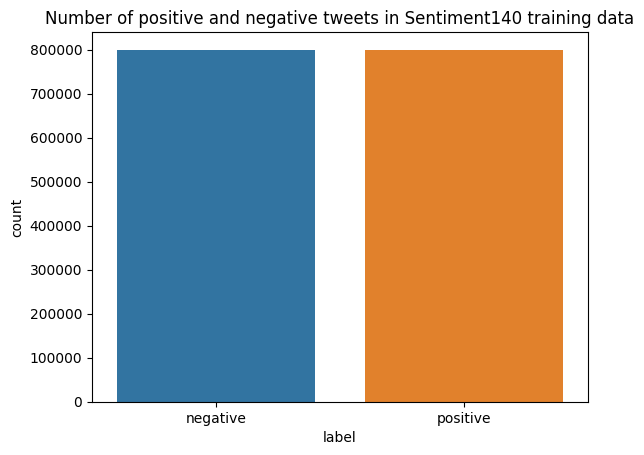

In [62]:
sentiment140Positive = sentiment140ProcessedDf[sentiment140ProcessedDf['label'] == 'positive']
sentiment140Negative = sentiment140ProcessedDf[sentiment140ProcessedDf['label'] == 'negative']
print("number of sentiment140 positive tweets: " + str(sentiment140Positive.shape[0]))
print("number of sentiment140 negative tweets: " + str(sentiment140Negative.shape[0]))
sns.countplot(x=sentiment140ProcessedDf['label'], label= 'count').set(title='Number of positive and negative tweets in Sentiment140 training data')


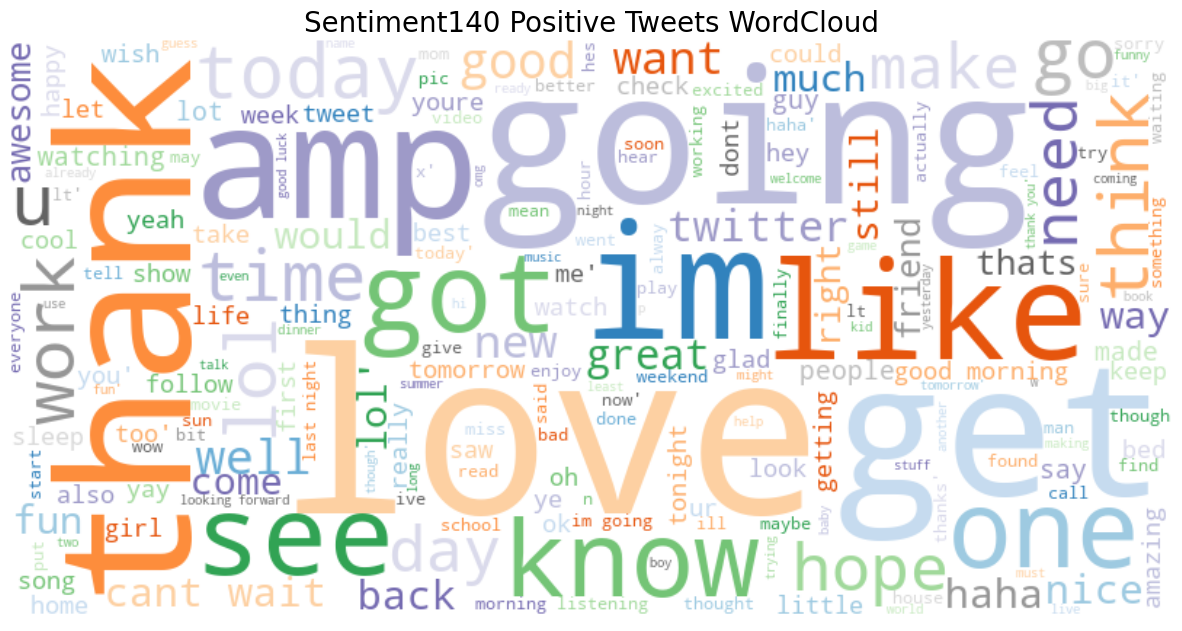

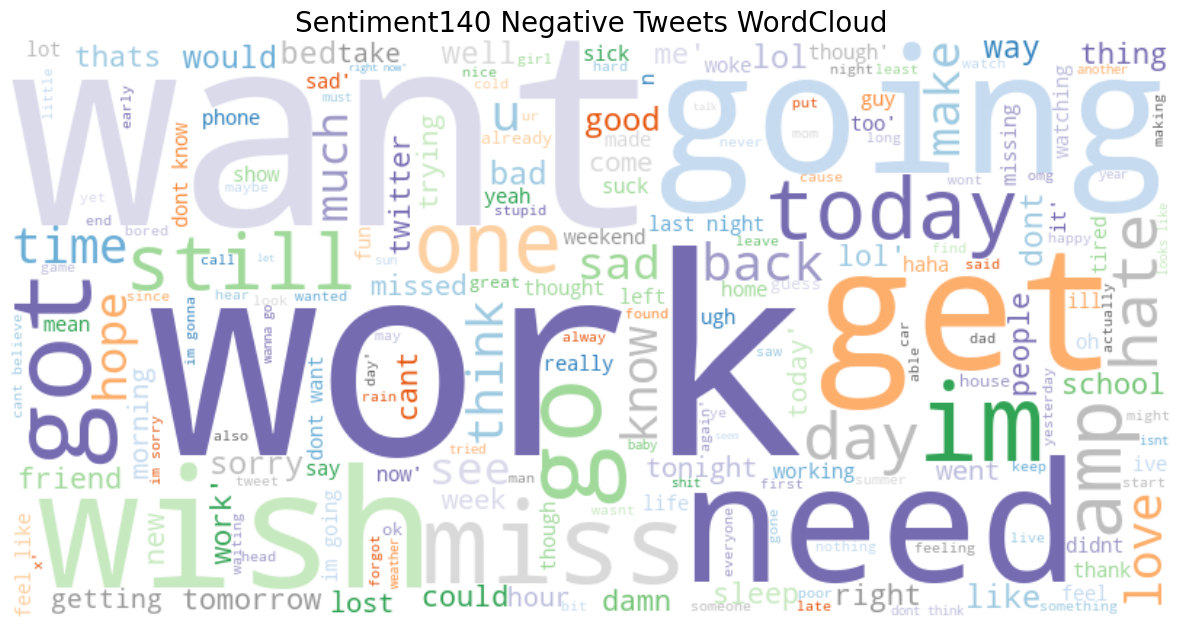

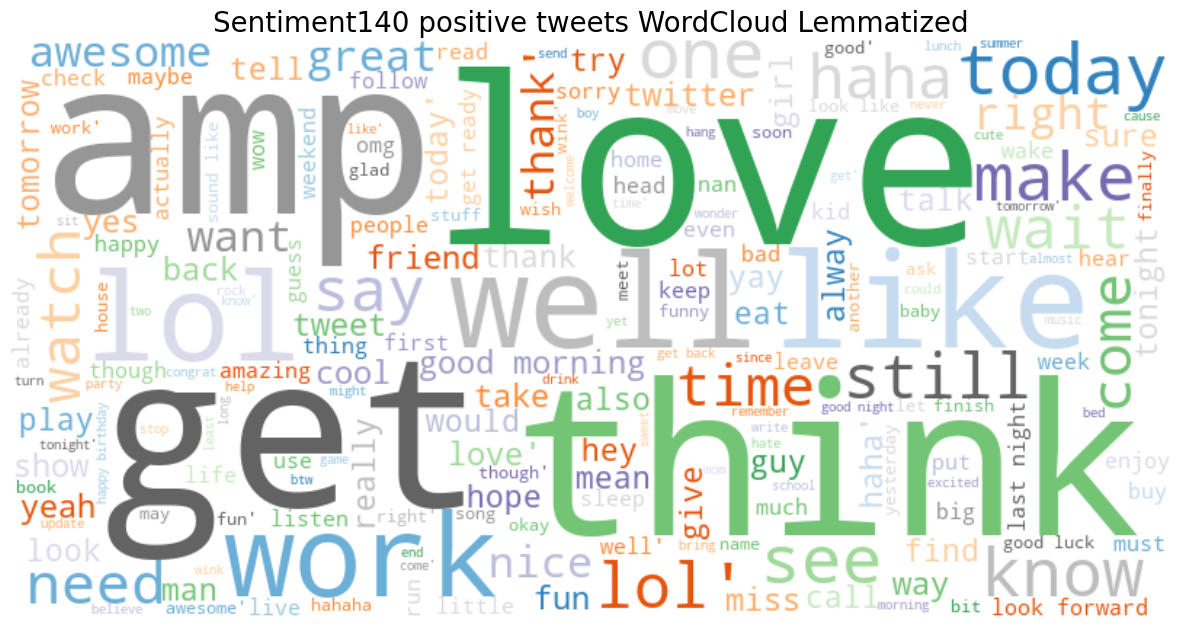

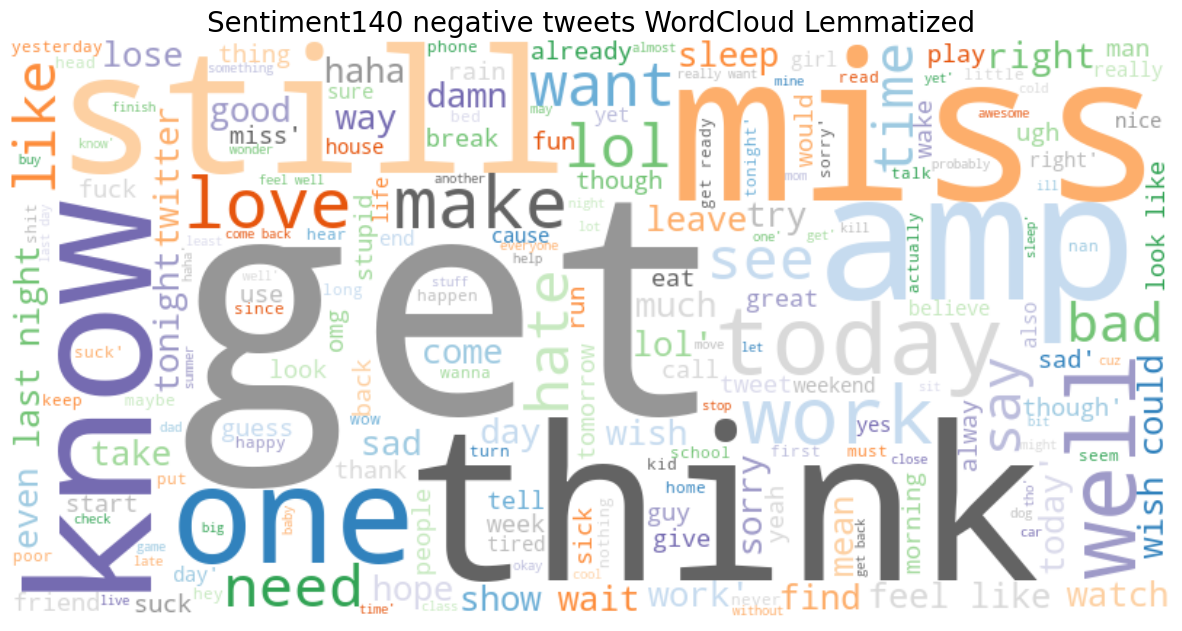

In [63]:
stops = set(stopwords.words('english'))

def tweetsDfToWC(df, dfCollumn, wcTitle, stopwordSet):
    tweets_list = df[dfCollumn].tolist()
    tweets_string = "".join(str(tweets_list))
    wc = WordCloud(width=800, height=400, background_color='white', colormap='tab20c', stopwords=stopwordSet).generate(tweets_string)
    plt.figure(figsize = (15,15))
    plt.title(wcTitle, fontsize = 20)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")

tweetsDfToWC(sentiment140Positive, "cleanTweet", "Sentiment140 Positive Tweets WordCloud", stops)
tweetsDfToWC(sentiment140Negative, "cleanTweet", "Sentiment140 Negative Tweets WordCloud", stops)
tweetsDfToWC(sentiment140Positive, "lemmatizedTweet", "Sentiment140 positive tweets WordCloud Lemmatized", stops)
tweetsDfToWC(sentiment140Negative, "lemmatizedTweet", "Sentiment140 negative tweets WordCloud Lemmatized", stops)


Creating SVM model, training model

In [64]:
# train test split on df collumns lemmatizedTweet and label
# when using columns converting data from str to numpy.str_
# https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

X_train,X_test,Y_train, Y_test = train_test_split(sentiment140ProcessedDf["lemmatizedTweet"].apply(lambda x: np.str_(x)), 
sentiment140ProcessedDf['label'].apply(lambda x: np.str_(x)), test_size=0.25, random_state=42)

print("Train: ", X_train.shape, Y_train.shape, "Test: ", (X_test.shape,Y_test.shape))

Train:  (1200000,) (1200000,) Test:  ((400000,), (400000,))


TF-IDF Vectoriser

In [65]:
sentiment140ProcessedDf.dtypes

sentimentScore      int64
tweet              object
label              object
cleanTweet         object
lemmatizedTweet    object
dtype: object

transforming the train dataset into a matrix containing TF-IDF values for words

In [66]:
# using TF-IDF to vectorise training text
# ngram_range 1,1 means only unigrams are considered
vectoriser = TfidfVectorizer(ngram_range=(1,1), max_features=500000)

#converting data from str to numpy.str_
# https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
# vectoriser.fit_transform(X_train.apply(lambda x: np.str_(x)))
# print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

# X_train = vectoriser.transform(X_train.apply(lambda x: np.str_(x)))
# X_test  = vectoriser.transform(X_test.apply(lambda x: np.str_(x)))

vectoriser.fit_transform(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print('Data Transformed.')


No. of feature_words:  324859
Data Transformed.


**training the svm classification model**

In [67]:
print(X_train.shape)
print(X_test.shape)

(1200000, 324859)
(400000, 324859)


In [68]:
svc_model = LinearSVC()
svc_model.fit(X_train, Y_train)

LinearSVC()

Evaluate model function sourced from: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

In [69]:
# source: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def evaluateModel(svcModel):
    y_pred = svcModel.predict(X_test)
    print(classification_report(Y_test, y_pred))
    cf_matrix = confusion_matrix(Y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    

              precision    recall  f1-score   support

    negative       0.77      0.75      0.76    199581
    positive       0.76      0.78      0.77    200419

    accuracy                           0.76    400000
   macro avg       0.76      0.76      0.76    400000
weighted avg       0.76      0.76      0.76    400000



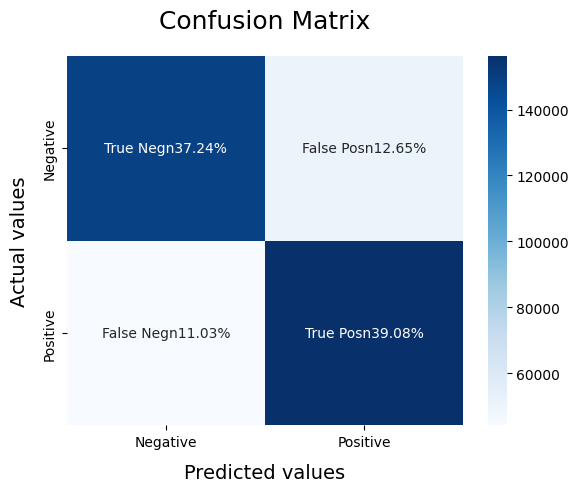

In [70]:
evaluateModel(svc_model)

This ROC curve is not working because data is trained on positive / negative label.
instead: train data on 0 / 1 label and pass this label instead. 

In [71]:


# source: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
Y_pred1 = svc_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

ValueError: y_true takes value in {'negative', 'positive'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.